\title{Assignment CA5 - Rental Bike} \author{Aditya Dey} \maketitle

Author: Aditya Dey

KaggleID: Adiitya.dey

# Data Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Importing Dataset
raw = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')
print(raw.shape)
raw.head(3)

(12165, 13)


,Season,Year,Month,Hour,Holiday,Weekday,Working day,Weather situation,Temperature (normalized),Feels-like temperature (normalized),Humidity (normalized),Windspeed,Rental bikes count
0,Summer,1,6,18,0,1,1,Clear or partly cloudy,0.76,0.6667,0.27,0.4478,791
1,Fall,1,10,11,0,3,1,Misty and/or cloudy,0.36,0.3485,0.66,0.2239,189
2,Spring,0,6,22,0,6,0,Clear or partly cloudy,0.64,0.6212,0.57,0.2239,190


In [4]:
# Replacing "missing" word with np.nan 
df1 = raw.replace(to_replace ="missing", value = np.nan).copy(deep='True')

# Dropping all np.nan rows since  they are minimal and do not seem to impact predictions.
df1.dropna(inplace=True)

In [5]:
# Converting objects to numerical data for training dataset
df_Season = pd.get_dummies(df1['Season'], prefix='Season')
df_Weather = pd.get_dummies(df1['Weather situation'], prefix='Weather')
df2 = pd.concat([df1, df_Season, df_Weather], axis=1)
df2.drop(["Season", "Weather situation"],axis=1, inplace=True)
df2.columns

df = df2[['Year', 'Month', 'Hour', 'Holiday', 'Weekday', 'Working day',
       'Temperature (normalized)', 'Feels-like temperature (normalized)',
       'Humidity (normalized)', 'Windspeed',
       'Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Weather_Clear or partly cloudy',
       'Weather_Heavy rain, heavy snow or thunderstorm',
       'Weather_Light snow or light rain', 'Weather_Misty and/or cloudy', 'Rental bikes count']]

In [6]:
# Converting objects to numerical data for test dataset
tst_Season = pd.get_dummies(test['Season'], prefix='Season')
tst_Weather = pd.get_dummies(test['Weather situation'], prefix='Weather')
tst = pd.concat([test, tst_Season, tst_Weather], axis=1)
tst.drop(["Season", "Weather situation"],axis=1, inplace=True)
tst.columns

Index(['Year', 'Month', 'Hour', 'Holiday', 'Weekday', 'Working day',
       'Temperature (normalized)', 'Feels-like temperature (normalized)',
       'Humidity (normalized)', 'Windspeed', 'Season_Fall', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'Weather_Clear or partly cloudy',
       'Weather_Heavy rain, heavy snow or thunderstorm',
       'Weather_Light snow or light rain', 'Weather_Misty and/or cloudy'],
      dtype='object')

<AxesSubplot:>

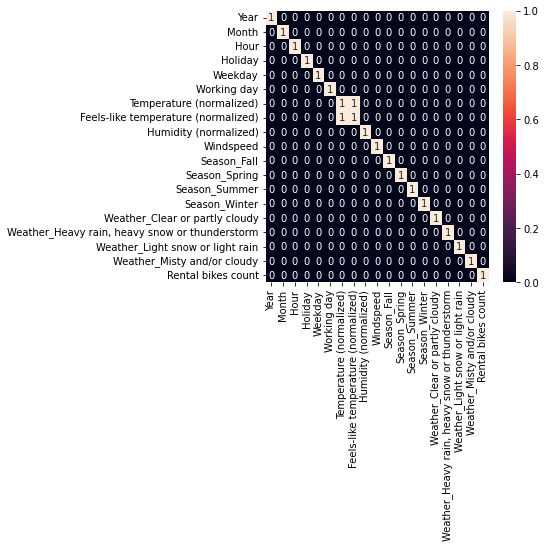

In [7]:
plt.figure(figsize=(5,5))
sns.heatmap(df.corr()> 0.90, annot=True)

There is only one high correlation between "Feels-like Temperature" and "Temperature". Further testing will provide more results on dropping which of the columns may give higher accuracy.

In [8]:
df.drop(["Feels-like temperature (normalized)"],axis=1, inplace=True)
tst.drop(["Feels-like temperature (normalized)"],axis=1, inplace=True)


/tmp/ipykernel_76419/45084172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["Feels-like temperature (normalized)"],axis=1, inplace=True)


# Creating Model

## Train test split

In [9]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [11]:
X_tst = tst.iloc[:,:].values

## Modelling

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RANSACRegressor

### RANSAC Regression

In [13]:
pipe_RAN = make_pipeline(StandardScaler(),
                         RANSACRegressor(random_state=1,
                                         min_samples=50,
                                         max_trials= 100,
                                        loss="absolute_error",
                                        residual_threshold=5.0))
pipe_RAN.fit(X_train, y_train)
y_train_pred = pipe_RAN.predict(X_train)
y_test_pred = pipe_RAN.predict(X_test)

print("MSE Train: {}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE Test: {}".format(mean_squared_error(y_test, y_test_pred)))

print("R2 Score Train: {}".format(r2_score(y_train, y_train_pred)))
print("R2 Score Test: {}".format(r2_score(y_test, y_test_pred)))


MSE Train: 4.152120411874473e+25
MSE Test: 22465.83013843706
R2 Score Train: -1.241911712111804e+21
R2 Score Test: 0.29606163893138704


- Mean squared error for train is too low compared to test which means the model is overfit.
- R2 score for train is negative representing chosen model fits worst than along horizontal line.


### RandomForest Regression 

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
pipe_rf = make_pipeline(StandardScaler(),
                        RandomForestRegressor(n_estimators=25,
                                              criterion='squared_error',
                                              random_state=1))
pipe_rf.fit(X_train,y_train)
y_train_pred = pipe_rf.predict(X_train)
y_test_pred = pipe_rf.predict(X_test)

print("MSE Train: {}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE Test: {}".format(mean_squared_error(y_test, y_test_pred)))

print("R2 Score Train: {}".format(r2_score(y_train, y_train_pred)))
print("R2 Score Train: {}".format(r2_score(y_test, y_test_pred)))

MSE Train: 319.66704701737336
MSE Test: 1874.168808163265
R2 Score Train: 0.9904386624113378
R2 Score Train: 0.9412752918073942


- Mean squared error of train is too low compared to test representing overfitting of data.
- R2 Score is very close to 1 for both train and test representing that model fits very closely.

### Elasticnet 

In [16]:
from sklearn.linear_model import ElasticNet

pipe_en = make_pipeline(StandardScaler(),
                       ElasticNet(alpha=1.0, l1_ratio=1.0, random_state=1))

pipe_en.fit(X_train,y_train)
y_train_pred = pipe_en.predict(X_train)
y_test_pred = pipe_en.predict(X_test)

print("MSE Train: {}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE Test: {}".format(mean_squared_error(y_test, y_test_pred)))

print("R2 Score Train: {}".format(r2_score(y_train, y_train_pred)))
print("R2 Score Train: {}".format(r2_score(y_test, y_test_pred)))

MSE Train: 20027.223427446304
MSE Test: 19247.088644635223
R2 Score Train: 0.4009797195549779
R2 Score Train: 0.3969168309224378


- High Mean Square Error represents model fit is worst.

---
At a quick glance with minimal parameters it clearly shows RandomForestRegressor surpasses ElasticNet and RANSAC with better r2_score. Therefore we will perform hyperparameter tuning with RandomForest.

### Hyperparamter Tuning

In [16]:
from sklearn.model_selection import GridSearchCV

pipe_rf = make_pipeline(StandardScaler(),
                        RandomForestRegressor(criterion='squared_error',
                                              random_state=1))

param_grid = [{'randomforestregressor__n_estimators': [50,100,500,1000],
              'randomforestregressor__max_depth':[None,20,40,50],
              }]

gs_rf = GridSearchCV(estimator=pipe_rf, cv=5, param_grid=param_grid)

gs_rf.fit(X_train,y_train)
print("Best Score: {}".format(gs_rf.best_score_))
print("Best Params: {}".format(gs_rf.best_params_))

Best Score: 0.9363646861446941
Best Params: {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 1000}


- Even though high number of estimators can increase accuracy but they also can increase overfitting.
- Currently for this dataset, it does not show any overfitting, so we will use 1000 estimators for final submission.

In [22]:
from sklearn.ensemble import RandomForestClassifier
tmp_bins = []

for i in range(2,11):
    y_bin = pd.cut(y,i, labels=False)
    X2 = X.copy()
    X2_train, X2_test, y_train_bin, y_test_bin = train_test_split(X2, y_bin, test_size=0.20, random_state=1)
    rfc = RandomForestClassifier(n_estimators=25, random_state=1)
    rfc.fit(X2_train, y_train_bin)
    y2_pred = rfc.predict(X2_test)
    
    correct_count = (y2_pred == y_test_bin).sum()
    accuracy = round((correct_count / y2_pred.shape[0]),3)
    
    tmp_bins.append([i, correct_count, accuracy])
    

binns = pd.DataFrame(tmp_bins, columns = ["bins", "Correct Count", "Accuracy"])
binns



,bins,Correct Count,Accuracy
0,2,2277,0.968
1,3,2173,0.924
2,4,2055,0.874
3,5,1967,0.836
4,6,1863,0.792
5,7,1778,0.756
6,8,1739,0.739
7,9,1701,0.723
8,10,1598,0.679


# Kaggle submission

In [18]:
#Training on complete dataset

pipe_rf = make_pipeline(StandardScaler(),
                        RandomForestRegressor(n_estimators=1000, criterion='squared_error',
                                              random_state=1))
pipe_rf.fit(X,y)

y_pred = pipe_rf.predict(X_tst)

pred_df = pd.DataFrame(y_pred, columns=(['Rental bikes count']))
pred_df = pred_df.reset_index()
pred_df.columns = ['idx','Rental bikes count']
pred_df.to_csv("Submission.csv", index = False)

#Public Score: 0.9311